# connect to db

In [14]:
server = 'ds059694.mongolab.com'
port = 59694
db_name = 'deepreader'
username = 'deepreaderuser'
password = '1ecolequimonte45'

from pymongo import MongoClient as Connection

# from pymongo import Connection

# what versions are we using
import sys
print 'Python version', sys.version

import pymongo
print 'Pymongo version', pymongo.version
##

# connect to server
print '\nConnecting ...'
conn = Connection(server, port)

# Get the database
print '\nGetting database ...'
db = conn[db_name]

# Have to authenticate to get access
print '\nAuthenticating ...'
db.authenticate(username, password)

Python version 2.7.10 |Anaconda 2.3.0 (64-bit)| (default, Nov  7 2015, 13:18:40) [MSC v.1500 64 bit (AMD64)]
Pymongo version 3.1.1

Connecting ...

Getting database ...

Authenticating ...


True

# get graph from db

In [15]:
graph = db.graph.find_one()
print graph.keys()

[u'nodes', u'_id', u'links']


In [16]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18.0, 12.0)
import networkx as nx

G = nx.Graph()
nodes = graph['nodes']
edges = graph['links']
for n in nodes:
    G.add_node(n['id'])

for e in edges:
    a = e['source']
    b = e['target']
    G.add_edge(a,b )
    

In [17]:
# >>> import networkx as nx
# >>> G=nx.Graph()
# >>> G.add_node("spam")
# >>> G.add_edge(1,2)


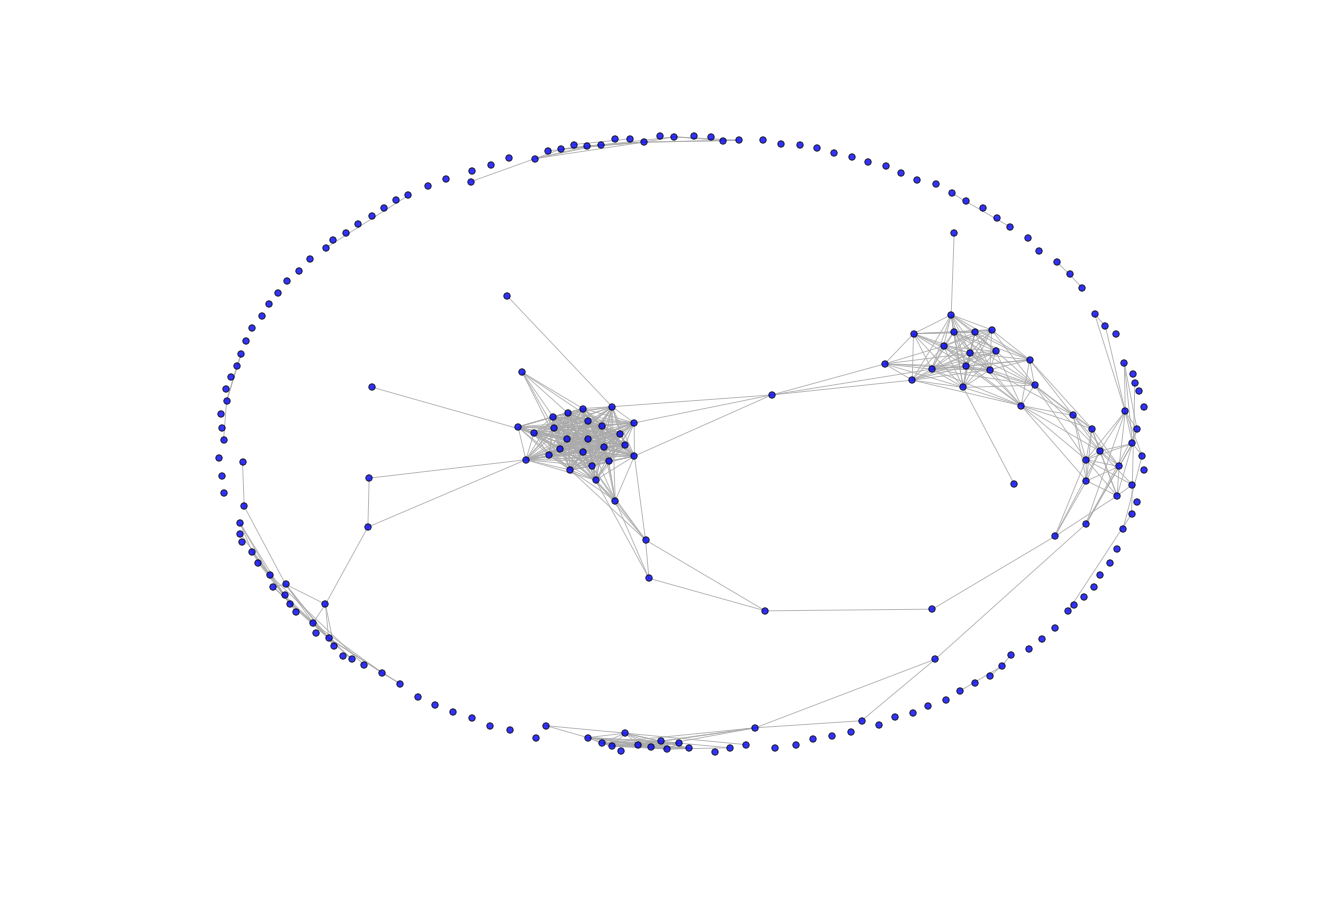

In [18]:
nx.draw(G, linewidths  = 1, node_size = 40, node_color = 'blue', edge_color = "#aaaaaa", alpha = 0.8)
plt.show()

In [19]:
H = nx.Graph(G)
graphs = list(nx.connected_component_subgraphs(H))
graphs.sort(key=lambda x: len( x.nodes() ), reverse = True)
GCC = graphs[0]

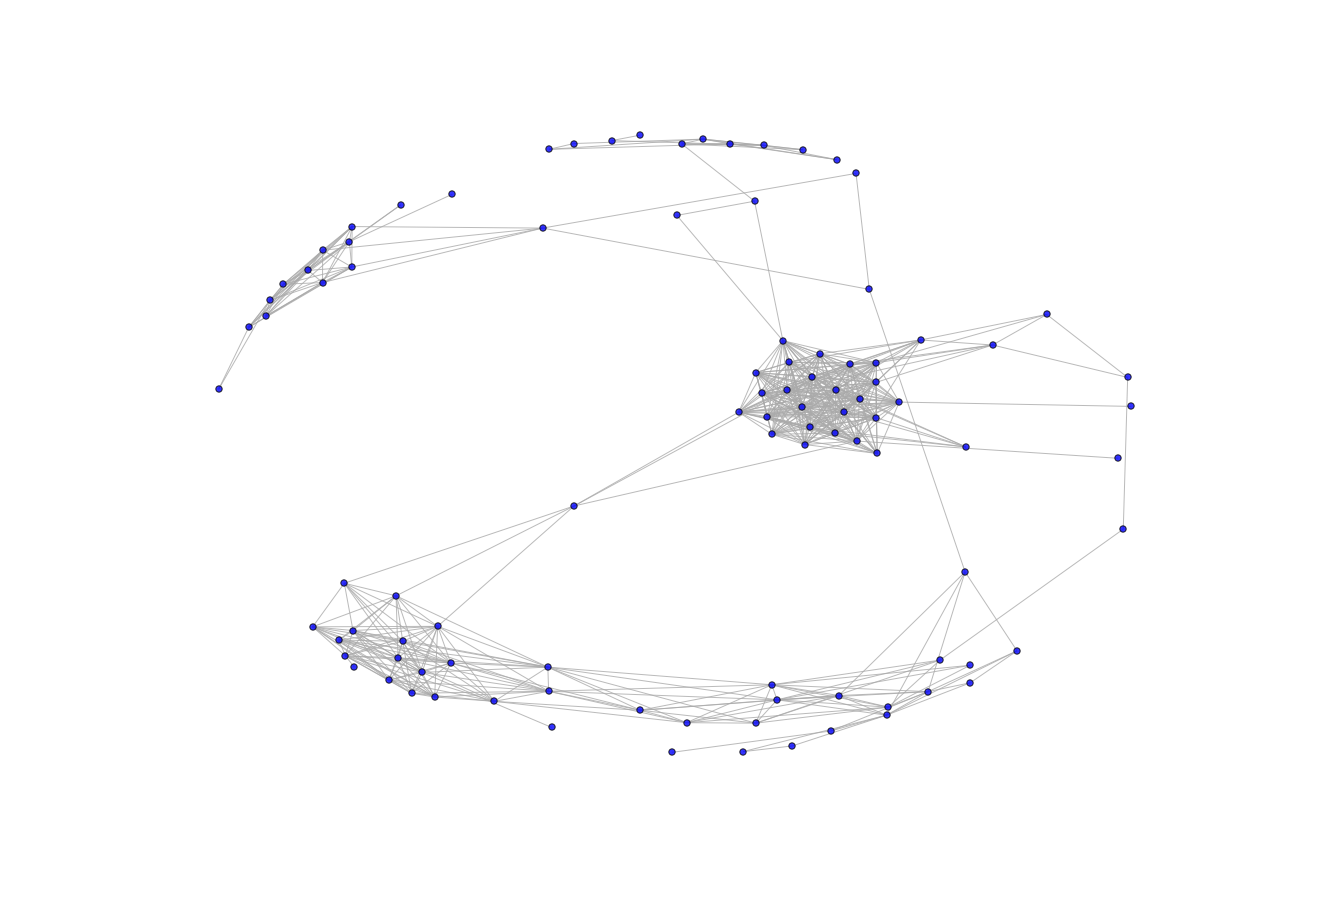

In [20]:
nx.draw(GCC, linewidths  = 1, node_size = 40, node_color = 'blue', edge_color = "#aaaaaa", alpha = 0.8)
plt.show()

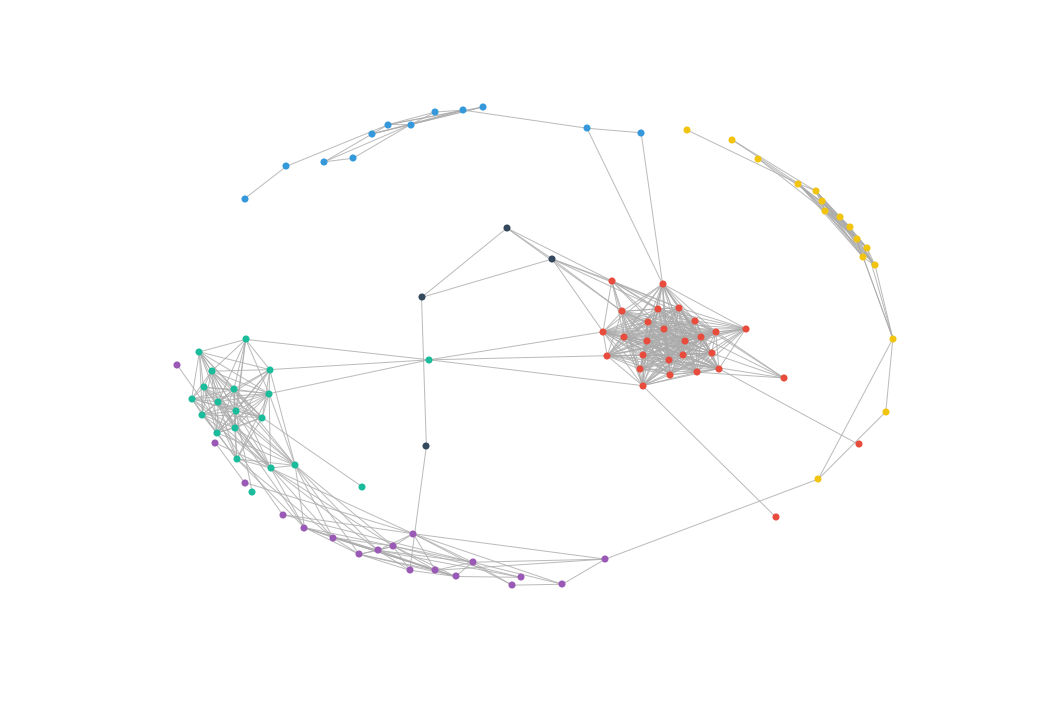

0.624684034806
6


In [23]:
import community
import matplotlib

colours = []
colours.append( "#7f8c8d")
colours.append( "#e74c3c")
colours.append( "#3498db")
colours.append( "#f1c40f")
colours.append( "#9b59b6")
colours.append( "#1abc9c")
colours.append( "#34495e")
colours.append( "#e67e22")


# matplotlib.rcParams['figure.figsize'] = (30.0, 20.0)
#first compute the best partition
def computeModularity ( graph_undirect, sub_graphs):
    M = 0
    L = len( graph_undirect.edges() )
    for c in sub_graphs:
        kc = 0
        for n in c:
            kc+= c.degree(n)
        Lc = len( c.edges() )
        M += ( float( Lc / float(L) - pow( float(kc) / ( 2.0 * float(L) ) ,2) ))
    return M


partition = community.best_partition(GCC)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(GCC)
count = 0.
nx.draw_networkx_edges(GCC,pos,  edge_color = "#aaaaaa", alpha = 0.8)
sub_graphs_louvain = []

for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(GCC, pos, list_nodes, linewidths = 0,  node_size = 50,
                                node_color = colours[int(count)])
    #place partition in subgraphs
    sub_graphs_louvain.append( GCC.subgraph(list_nodes ) )


plt.axis('off')
plt.show()

print computeModularity ( GCC, sub_graphs_louvain)
print len(sub_graphs_louvain)

# update document in db

In [75]:
communities = []
for n in graph['nodes']:
    id_db = n['id_db']
#     print db.documents.find_one( {"_id": id_db} )
#     print id_db
    id = n['id']
#     print id
    community = -1
    k = 0
    for sub in sub_graphs_louvain:
        if id in sub.nodes():
            community = k
        k += 1
        
#     print community
#     db.documents.update_one({"_id": str(id_db)},{"$set": {"community": community}})
    communities.append(community)
    
k = 0
new_nodes = []
for n in graph['nodes']:
    n['community'] = communities[k]
    new_nodes.append(n)
    k += 1
    
# for doc in db.documents.find():
#     db.documents.update_one({"_id": doc['_id']},{"$set": {"community": communities[k]}})
#     k += 1

In [77]:
new_graph = graph
new_graph['nodes'] = new_nodes
db.graph.drop()
db.graph.insert(  new_graph )

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.


ObjectId('5664a6949f5c8d3440dcb980')

In [68]:
cur = db.documents.find()
k = 0
for doc in cur:
#     print doc.keys()
#     print 
    print doc['community']
    if k > 100:
        break
    k += 1
#     print 
#     print sub_graphs_louvain[0].nodes()

[u'translator', u'topicsGraph', u'full_text', u'title', u'significantWords', u'community', u'tokens', u'full_topics', u'complexity', u'_id', u'type', u'semantic_vec']
-1
[u'translator', u'topicsGraph', u'full_text', u'title', u'significantWords', u'community', u'tokens', u'full_topics', u'complexity', u'_id', u'type', u'semantic_vec']
-1
[u'translator', u'topicsGraph', u'full_text', u'title', u'significantWords', u'community', u'tokens', u'full_topics', u'complexity', u'_id', u'type', u'semantic_vec']
-1
[u'translator', u'topicsGraph', u'full_text', u'title', u'significantWords', u'community', u'tokens', u'full_topics', u'complexity', u'_id', u'type', u'semantic_vec']
-1
[u'translator', u'topicsGraph', u'full_text', u'title', u'significantWords', u'community', u'tokens', u'full_topics', u'complexity', u'_id', u'type', u'semantic_vec']
-1
[u'translator', u'topicsGraph', u'full_text', u'title', u'significantWords', u'community', u'tokens', u'full_topics', u'complexity', u'_id', u'type', 

In [56]:
result = db.documents.update_one(
    {"_id": doc['_id']},
    {"$set": {"community": 0}}
)

In [57]:
doc = db.documents.find_one()
print doc.keys()


[u'translator', u'topicsGraph', u'full_text', u'title', u'significantWords', u'community', u'tokens', u'full_topics', u'complexity', u'_id', u'type', u'semantic_vec']
